# Group project

Analysis of competitiveness of different energy production technologies in Danish Electricity Market

## Modeling of current energy system

### Data gathering and analysis

Latest energy statistics reports available is for 2018. Thereforte, all data used is dated to year 2018.

Hourly consumption, production, as well as wind energy production data available from https://www.nordpoolgroup.com/historical-market-data/

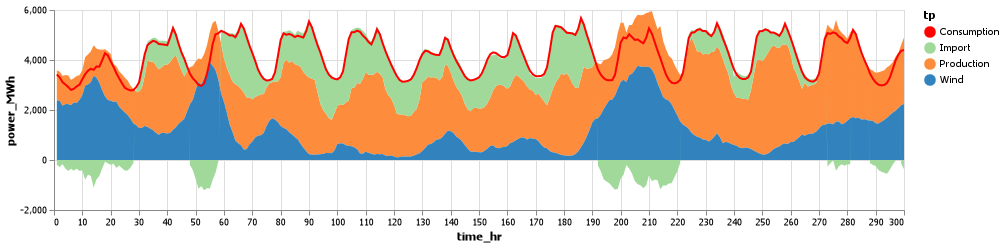

In [1]:
using CSV, VegaLite, DataFrames

consum = CSV.read("consumption-dk-areas_2018_hourly.csv")
produc = CSV.read("production-dk-areas_2018_hourly.csv")
wind = CSV.read("wind-power-dk_2018_hourly.csv")
exp = CSV.read("exchange-per-country_2018_hourly.csv")

n = 300

#production with wind substracted
dif = produc[1:n,"DK"]-wind[1:n,"DK"]

data = vcat(DataFrame(time_hr=collect(1:n),power_MWh = consum[1:n,"DK"], tp = "Consumption",source = 2),           
            DataFrame(time_hr=collect(1:n),power_MWh = dif, tp ="Production",source = 1),
            DataFrame(time_hr=collect(1:n),power_MWh = wind[1:n,"DK"], tp = "Wind",source = 1),
            DataFrame(time_hr=collect(1:n),power_MWh = exp[1:n,"DK"], tp = "Import",source = 1))

#Plotting data
data |>
@vlplot(width=850, hieght=700)+
@vlplot(mark=:area, x=:time_hr, y={:power_MWh,stack=:zero},color=:tp,transform=[{filter="datum.source==1"}]) +
@vlplot(mark=:line, x=:time_hr, y=:power_MWh, transform=[{filter="datum.source==2"}],
    color={:tp,
    scale={range = ["red","#a1d99b","#fd8d3c","#3182bd"]}})


+ Total energy demand is covered by the combination of local energy production and import of energy from neighbouring countries
+ Big part of electric energy is covered by the wind power production
+ The difference is covered by the combination of renewable and non-renewable sources

Share of production technologies in energy mix can be found in Energy Statistics Report for 2018 by Danish Energy Agency (https://ens.dk/en/our-services/statistics-data-key-figures-and-energy-maps/annual-and-monthly-statistics) 

For the simulation all units could be represented in a model, but only most feasable units are dispatched to cover difference between wind and consumption.

### Modeling
Energy system could be modeled based on the data from above. In this case the system would consist of already deployed units and investment opportunities what will further optimize the system (Minimize costs). Wind production will be substracted from consumption for each of the time steps and optimization for mix of technologies covering the difference will be made.

Additional information required:
+ Operational prices for existing power plants based on type of plant/fuel
+ Investment prices (price per KW) for further investments 


In [2]:
inp = DataFrame(Name            = ["Solar PV","Wind Onshore","Wind Offshore","Biogas","Brown coal","Hard coal","CCGT","GT"],
                Capex_avg       = [700,1750,3900,3000,1900,1650,950,500],    #investment cost EUR/kW (nominal capacity)
                Lifetime        = [25,25,25,30,40,40,30,30],                 #Years
                Opex_of_capex   = [0.025,0,0,0.04,0,0,0,0],                  #EUR/kw % of CAPEX
                Opex_fix        = [0,30,100,0,36,32,22,20],                  #EUR/Kw
                Opex_var        = [0,0.005,0.005,0,0.005,0.005,0.004,0.003], #EUR/kwh
                Fuel_price      = [0,0,0,30.3,1.8,9.6,21,21],                #EUR/MWh heat
                Fuel_eff        = [1,1,1,0.4,0.45,0.46,0.6,0.6])             #el. eng. % of heat en

,Name,Capex_avg,Lifetime,Opex_of_capex,Opex_fix,Opex_var,Fuel_price
,String,Int64,Int64,Float64,Int64,Float64,Float64
1,Solar PV,700,25,0.025,0,0.0,0.0
2,Wind Onshore,1750,25,0.0,30,0.005,0.0
3,Wind Offshore,3900,25,0.0,100,0.005,0.0
4,Biogas,3000,30,0.04,0,0.0,30.3
5,Brown coal,1900,40,0.0,36,0.005,1.8
6,Hard coal,1650,40,0.0,32,0.005,9.6
7,CCGT,950,30,0.0,22,0.004,21.0
8,GT,500,30,0.0,20,0.003,21.0


### Estiamtion of the capacity factor

In [3]:
T = size(consum)[1]
#capacity factor
c = []
append!(c, wind[i,"DK"]/maximum(wind[1:T,"DK"]) for i=1:T)    #capacity factor
maximum(consum[1:8761,"DK"])

5675

### Mathematical  formualtion

**Variables:** 
<br> $p_{it}$ production of technology i in time unit t
<br> $p_i^{max}$ max power production of unit i

**Parameters:**
<br> $a$ - operations varaible cost [EUR/KWh]
<br> $f$ - fuel costs [EUR/KWh]
<br> $e$ - fuel efficiency [\$]
<br> $b$ - CAPEX [EUR/KWh]
<br> $l$ - expected system lifetime [yr.]
<br> $o$ - fixed operational expenses [EUR/kw % of CAPEX]
<br> $k$ - fixed operational expenses [EUR/kw]
<br> $d$ - demand for power [Mw]
<br> $c$ - capacity factor 

**Objective:** 
<br>to minimize cost of electricity

$$Z = \dfrac{\sum_{t=1}^{T}\sum_{i=1}^{n}p_{it} \left( a_i+ f_ie_i\right) + 
\sum_{i=1}^{n} \dfrac{p^{max}_{i}}{l_{i}}\left(b_i(1+o_i)+k_{i} \right)}{\sum_{t=1}^{T}d_t} \tag{1}$$

$$p_{it}\leq p^{max}_i \tag{2} $$

$$p_{wt} = p^{max}_w c_{wt} \tag{3} $$

$$\sum_{t=1}^{T}\sum_{i=1}^{I} p_{it} \geq d_t \tag{4} $$

$$p_{it},p_{i}^{max} \geq 0 $$

In [29]:
using CSV, JuMP, GLPK

n = size(inp)[2]
T = 1000
M = 10*maximum(consum[1:T,"DK"])

m = Model(with_optimizer(GLPK.Optimizer))

@variable(m,p[i=1:n,t=1:T] >= 0)        #power per technology
@variable(m,pmax[i=1:n] >= 0)           #power per technology
@variable(m,u[i=1:n], Bin)         #controling number of technologies

@objective(m, Min, (sum(p[i,t]*                      (inp[i,"Opex_var"] + inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])            for i=1:n for t=1:T) +
                    sum((pmax[i]/inp[i,"Lifetime"])* (inp[i,"Capex_avg"]*(1+inp[i,"Opex_of_capex"])+inp[i,"Opex_fix"])      for i=1:n))/
                    sum(consum[t,"DK"]                                                                                      for t=1:T))

@constraint(m, Solar[t=1:T],                 p[1,t] <= pmax[1])                        #Solar
@constraint(m, OnShoreWind[t=1:T],           p[2,t] == pmax[2]*c[t])             #Onshore wind
@constraint(m, OffShoreWind[t=1:T],          p[3,t] == pmax[3]*c[t])            #Offshore wind
@constraint(m, NotIntermittent[i=4:n,t=1:T], p[i,t] <= pmax[i])       #not intermittent

@constraint(m, Demand[t=1:T], sum(p[i,t] for i=1:n) >= consum[t,"DK"]) #Demand
                
#TEMPORARY limiting use of solar
@constraint(m, pmax[1]  <= 2000 )
                
#limiting number of technologies
@constraint(m,[i=1:n],pmax[i] <=M*u[i])
@constraint(m, sum(u[i] for i=1:n) <= 3)           #number of technologies allowed

optimize!(m)                            
                
println("Cost of electricity levelzied: ", JuMP.objective_value(m)," EUR" )
# Levelized println("Cost of electricity per year: ", JuMP.objective_value(m)/sum(consum[1:T,"DK"])/1000," EUR/kWh" )
println("Total power produced: ", sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T)," MWh")
println("Total power demand: "  , sum(consum[1:T,"DK"]), " MWh")
println("Total investments: ",    sum(JuMP.value.(pmax[i])*inp[i,"Capex_avg"] for i=1:n), " EUR" )
println("Operational costs: ",    sum(inp[i,"Opex_var"]*JuMP.value.(p[i,t]) for i=1:n for t=1:T)/sum(consum[1:T,"DK"]), " EUR/MWh")
println("")

for i=1:n
    println(inp[i,"Name"])
    println("Required capacity: ", JuMP.value.(pmax[i]), " MWh")
    println("Investments: ", JuMP.value.(pmax[i])*inp[i,"Capex_avg"], " EUR" )
    println("Operational expenses: ", sum(JuMP.value.(p[i,t]) for t =1:T)*inp[i,"Opex_var"] , " EUR" )   #Finalzie by adding fixed operational costs
    println("")

end

Cost of electricity levelzied: 0.30771341970562877 EUR
Total power produced: 5.079558904240754e6 MWh
Total power demand: 4237238 MWh
Total investments: 1.9311902439580485e7 EUR
Operational costs: 0.00363392250357516 EUR/MWh

Solar PV
Required capacity: 2000.0 MWh
Investments: 1.4e6 EUR
Operational expenses: 0.0 EUR

Wind Onshore
Required capacity: 6367.374829001368 MWh
Investments: 1.1142905950752394e7 EUR
Operational expenses: 11661.567152302796 EUR

Wind Offshore
Required capacity: 0.0 MWh
Investments: 0.0 EUR
Operational expenses: 0.0 EUR

Biogas
Required capacity: 0.0 MWh
Investments: 0.0 EUR
Operational expenses: 0.0 EUR

Brown coal
Required capacity: 3562.6297309621523 MWh
Investments: 6.768996488828089e6 EUR
Operational expenses: 3736.227368901051 EUR

Hard coal
Required capacity: 0.0 MWh
Investments: 0.0 EUR
Operational expenses: 0.0 EUR

CCGT
Required capacity: 0.0 MWh
Investments: 0.0 EUR
Operational expenses: 0.0 EUR

GT
Required capacity: 0.0 MWh
Investments: 0.0 EUR
Operat

### Visualization

WARN Missing type for channel "color", using "nominal" instead.
WARN Missing type for channel "color", using "nominal" instead.


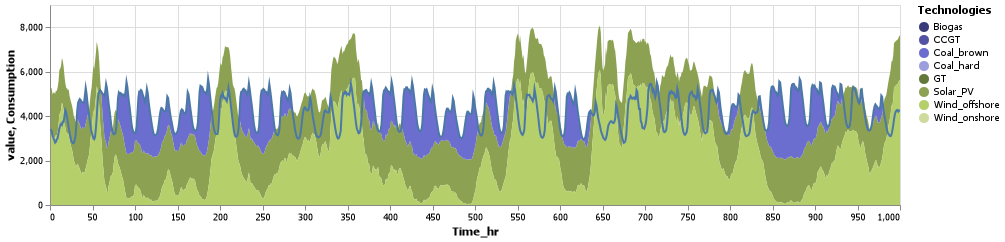

In [28]:
Data = DataFrame(Time_hr       = collect(1:T), 
                 Solar_PV      = JuMP.value.(p[1,1:T]),
                 Wind_offshore = JuMP.value.(p[2,1:T]),
                 Wind_onshore  = JuMP.value.(p[3,1:T]),
                 Biogas        = JuMP.value.(p[4,1:T]),
                 Coal_brown    = JuMP.value.(p[5,1:T]),
                 Coal_hard     = JuMP.value.(p[6,1:T]),
                 CCGT          = JuMP.value.(p[7,1:T]),
                 GT            = JuMP.value.(p[8,1:T]),
                 Consumption   = consum[1:T,"DK"])

d = T   #plotting range
#Plotting data
Data[1:d,:] |>
stack |>         #Stacking data
@vlplot(width=850, hieght=700)+
@vlplot(mark=:area, x=:Time_hr, y={:value,stack=:zero},color={:variable,
    scale={scheme="category20b"},
    legend={title="Technologies"}
    }
)+
@vlplot(mark=:line, x=:Time_hr, y=:Consumption)

### Sensitivity analysis

In [28]:
#Get dual prices

println(getdual(NotIntermittent[4,1000]))

0.0


### Old costs

In [ ]:
tech = ["Onshore wind","Offshore wind","Solar PV","Biomass","Gas"]
a = [0.053 0.115 0.068 0.066]*1000 #price 
b = [1549 4245 1208 1693]*1000     #investments USD/MWH
lifetime = [20,20,20,20]

### Further model improvements

Ideas for further model improvements:
+ Green transition requirements (100% of electric energy from Renewables)
+ Backup generation requirements
+ Including price of fuel and CO2 tax
+ Energy import and export
+ Subsidy for renewables